# ANOVA comparison of model evaluation results

## Import Libraries

In [32]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

## Save Plots Switch

In [2]:
save_plots = True

## Import Data to be compared

In [3]:
rfc_data = pd.read_csv('./output_datasets/rfc_datasets/cross_validation_results.csv')
svm_data = pd.read_csv('./output_datasets/svm_datasets/cross_validation_results.csv')
knn_data = pd.read_csv('./output_datasets/knn_datasets/cross_validation_results.csv')

In [4]:
#rfc_data.head()

## Average Columns to produce Round Medians

In [5]:
rfc_class_medians = pd.DataFrame(rfc_data.median(axis=1))

In [6]:
rfc_class_medians.columns = ['f1_score']

In [7]:
rfc_class_medians.insert(0, "ml_method",'RFC')

In [8]:
#rfc_class_medians.head()

In [9]:
svm_class_medians = pd.DataFrame(svm_data.median(axis=1))

In [10]:
svm_class_medians.columns = ['f1_score']

In [11]:
svm_class_medians.insert(0, "ml_method",'SVM')

In [12]:
#svm_class_medians.head()

In [13]:
knn_class_medians = pd.DataFrame(knn_data.median(axis=1))

In [14]:
knn_class_medians.columns = ['f1_score']

In [15]:
knn_class_medians.insert(0, "ml_method",'KNN')

In [67]:
#knn_class_medians.head()

## Merge rfc, svm, knn medians into single df

In [17]:
ml_medians = pd.concat([rfc_class_medians, svm_class_medians, knn_class_medians])

ml_method     3
f1_score     25
dtype: int64

## Visualise Median F1 Scores per Technique

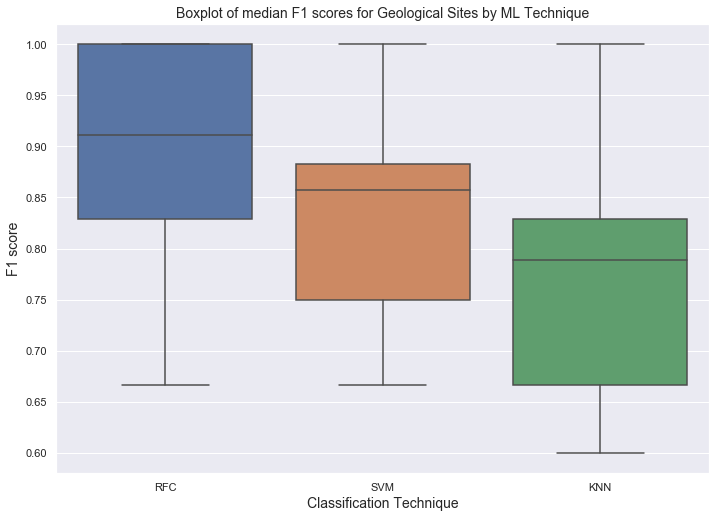

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(x = ml_medians['ml_method'], y = ml_medians['f1_score'])
plot.set_title('Boxplot of median F1 scores for Geological Sites by ML Technique', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 14})
plot.set_xlabel("Classification Technique", fontdict={'fontsize': 14})

if save_plots:
    fig = plot.get_figure()
    #fig.savefig('final_figures/ML_Technique_F1s_comparison_boxplot.png')

## Conduct ANOVA

In [24]:
lm = ols('f1_score ~ ml_method',data=ml_medians).fit()
aov_table = sm.stats.anova_lm(lm)
print(aov_table)

             df    sum_sq   mean_sq         F    PR(>F)
ml_method   2.0  0.163310  0.081655  6.815376  0.002481
Residual   48.0  0.575086  0.011981       NaN       NaN


In [25]:
"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
From - https://www.pythonfordatascience.org/anova-python/ 
"""

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
ml_method,0.163310,2.0,0.081655,6.815376,0.002481,0.221168,0.185704
Residual,0.575086,48.0,0.011981,NaN,NaN,NaN,NaN


## Test for Normality

In [30]:
stats.shapiro(lm.resid) #W-test statistic, p-value

(0.972887396812439, 0.29040753841400146)

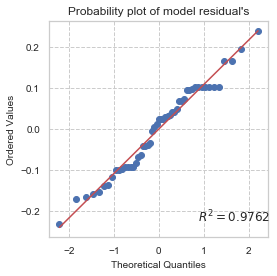

In [62]:
sns.set_style("whitegrid",{'grid.linestyle': 'dashed'})
fig = plt.figure(figsize= (4, 4))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 12)
ax.set

ax.set_xlabel('Theoretical Quantiles',fontsize=10)
ax.set_ylabel('Ordered Values',fontsize=10)

plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.tight_layout()

plt.show()

## Levene's test of homogeneity

In [36]:
stats.levene(ml_medians['f1_score'][ml_medians['ml_method'] == 'RFC'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'SVM'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'KNN'])

LeveneResult(statistic=0.4285340906398199, pvalue=0.6539311766926287)

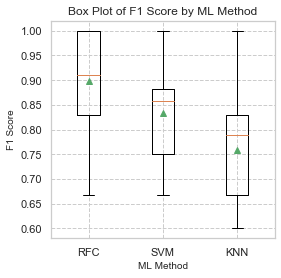

In [51]:
fig = plt.figure(figsize= (4, 4))
sns.set_style("whitegrid",{'grid.linestyle': 'dashed'})

ax = fig.add_subplot(111)

ax.set_title('Box Plot of F1 Score by ML Method', fontsize= 12)
ax.set

data = [ml_medians['f1_score'][ml_medians['ml_method'] == 'RFC'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'SVM'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'KNN']]

ax.boxplot(data, labels= ['RFC', 'SVM', 'KNN'], showmeans= True)

plt.xlabel('ML Method',fontsize=10)
plt.ylabel('F1 Score',fontsize=10)

plt.show()

if save_plots:
    fig = plot.get_figure()
    fig.savefig(filepath)

## Tukey's HSD (Honestly Significant Difference)

In [39]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(ml_medians['f1_score'], ml_medians['ml_method'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
KNN,RFC,0.1385,0.0016,0.0477,0.2293,True
KNN,SVM,0.0738,0.1319,-0.017,0.1646,False
RFC,SVM,-0.0647,0.2068,-0.1555,0.0261,False


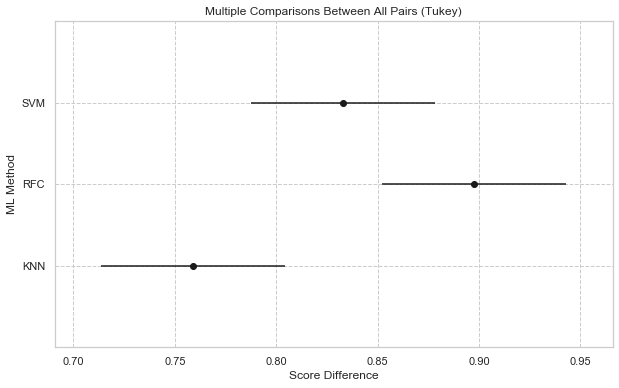

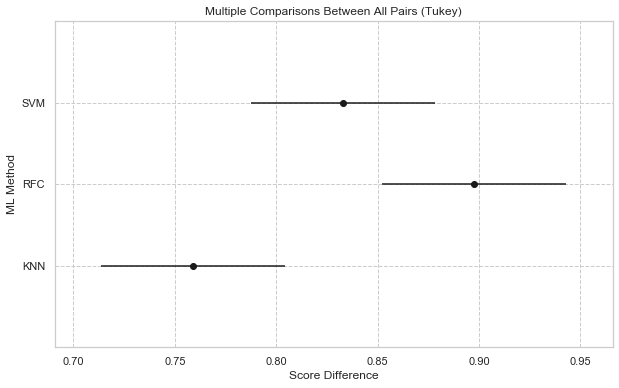

In [53]:
sns.set_style("whitegrid",{'grid.linestyle': 'dashed'})
post_hoc_res.plot_simultaneous(ylabel= 'ML Method', xlabel= 'Score Difference')

if save_plots:
    fig = plot.get_figure()
    fig.savefig(filepath)

## Bonferroni Correction

In [43]:
comp = mc.MultiComparison(ml_medians['f1_score'], ml_medians['ml_method'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= 'bonf')

tbl

group1,group2,stat,pval,pval_corr,reject
KNN,RFC,-3.5358,0.0013,0.0038,True
KNN,SVM,-1.9562,0.0592,0.1776,False
RFC,SVM,1.8154,0.0788,0.2365,False


## Sidak Correction

In [44]:
comp = mc.MultiComparison(ml_medians['f1_score'], ml_medians['ml_method'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= 'sidak')

tbl

group1,group2,stat,pval,pval_corr,reject
KNN,RFC,-3.5358,0.0013,0.0038,True
KNN,SVM,-1.9562,0.0592,0.1673,False
RFC,SVM,1.8154,0.0788,0.2184,False
